# Setup

This is the most popular, fast, twitter tuned sentiment analysis classifier on Huggingface:
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

Also, I've used it in published research already with success.


In [ ]:
import os
from pathlib import Path
import sys

# --- REPO ROOT ON sys.path (so `from src.*` works locally) ---
_REPO_ROOT = str(Path(os.getcwd()).resolve().parents[1])
if _REPO_ROOT not in sys.path:
    sys.path.insert(0, _REPO_ROOT)


# --- ENVIRONMENT SWITCH ---
# Set to True if running on local machine with Google Drive Desktop mounted
# Set to False if running in Google Colab cloud
RUNNING_LOCALLY = True

if RUNNING_LOCALLY:
    # Standard macOS path for Google Drive Desktop
    BASE_PATH = Path('/Volumes/GoogleDrive/MyDrive/AI Public Trust')
else:
    # Google Colab cloud path
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/AI Public Trust')

# Pre-compute critical paths used across notebooks
twits_folder = BASE_PATH / 'Raw Data/Twits/'
test_folder = BASE_PATH / 'Raw Data/'
datasets_folder = BASE_PATH / 'Data Sets'
cleanedds_folder = BASE_PATH / 'Data Sets/Cleaned Data'
networks_folder = BASE_PATH / 'Data Sets/Networks/'
literature_folder = BASE_PATH / 'Literature/'
topic_models_folder = BASE_PATH / 'Models/Topic Modeling/'


In [ ]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from collections import Counter
import json
import time
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import random
import networkx as nx
import re
import string

from pathlib import Path
# from google.colab import drive
# drive.mount('/content/drive')

# %%
# ──────────────────────────────────────────────────────────────────────────────
# 1. Drive Mount & Paths
# ──────────────────────────────────────────────────────────────────────────────
# drive.mount('/content/drive')

# Base project folder (Ignacio standard)
# BASE = Path('/content/drive/My Drive/Colab Projects/AI Public Trust')


# twits_folder = BASE / 'Raw Data/Twits/'
# test_folder = BASE / 'Raw Data/'
# print("Current Directory:", twits_folder)
# datasets_folder = BASE / 'Data Sets'
# cleanedds_folder = BASE / 'Data Sets' / 'Cleaned Data'
# block_folder = BASE / 'Data Sets' / 'Cleaned Data' / 'Blocks'
# networks_folder = BASE / 'Data Sets' / 'Networks'

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/My Drive/Colab Projects/AI Public Trust/Raw Data/Twits


# Sanity Check

In [ ]:
# This is the processing function that the authors of the classifier provide.
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

## Sanity Check Test

In [ ]:
# Check how it looks, LINE BY LINE
# CHECKING FOR TYPES OF TWEET THAT ARE NOT ORIGINAL
AItrust_twits_dict_test = open(cleanedds_folder/'AItrust_pruned_twits_test.json','r',encoding='utf-8')

i = 0
for line in AItrust_twits_dict_test:
    twit = json.loads(line)
    #print(twit)
    try:
      i+=1
      print(twit['referenced_tweets'])
      print(twit['type'])
      print(twit.keys())
      print('This is the original tweet:')
      print(twit['text'])
      print('\n')
      print('This is the clean tweet:')
      print(preprocess(twit['text']))
      print(twit['created_at'])
      print('------')
    except:
      pass
    #print('------')
    if i>5:
        break
AItrust_twits_dict_test.close()

1592178048002326529
retweeted
dict_keys(['id', 'text', 'created_at', 'public_metrics', 'author_id', 'type', 'referenced_tweets', 'conversation_id', 'referenced_tweets_dictionary', 'processed_text'])
This is the original tweet:
RT @WonderBotz: GENIE automatically captures all user activity and utilizes one-of-a-kind AI to create process flows and actionable insight…


This is the clean tweet:
RT @user GENIE automatically captures all user activity and utilizes one-of-a-kind AI to create process flows and actionable insight…
2022-11-15T00:09:59.000Z
------


## Sanity Test Full

In [ ]:
# Check how it looks, LINE BY LINE
# CHECKING FOR TYPES OF TWEET THAT ARE NOT ORIGINAL
AItrust_twits_dict = open(cleanedds_folder/'AItrust_pruned_twits.json','r',encoding='utf-8')

i = 0
for line in AItrust_twits_dict:
    twit = json.loads(line)
    #print(twit)
    try:
      i+=1
      print(twit['referenced_tweets'])
      print(twit['type'])
      print(twit.keys())
      print('This is the original tweet:')
      print(twit['text'])
      print('\n')
      print('This is the clean tweet:')
      print(preprocess(twit['text']))
    except:
      pass
    #print('------')
    if i>5:
        break
AItrust_twits_dict_test.close()

1622638090752753679
retweeted
dict_keys(['id', 'text', 'created_at', 'public_metrics', 'author_id', 'type', 'referenced_tweets', 'conversation_id', 'referenced_tweets_dictionary', 'processed_text'])
This is the original tweet:
RT @lallamapic: La Llama is checked ✅🤣

Who wants a draw for a Checks VV edition ($3200)⁉️

Requirements:
1. RT, Like &amp; Follow @lallamapic…


This is the clean tweet:
RT @user La Llama is checked ✅🤣

Who wants a draw for a Checks VV edition ($3200)⁉️

Requirements:
1. RT, Like &amp; Follow @user
1622280318861418497
retweeted
dict_keys(['id', 'text', 'created_at', 'public_metrics', 'author_id', 'type', 'referenced_tweets', 'conversation_id', 'referenced_tweets_dictionary', 'processed_text'])
This is the original tweet:
RT @lexfridman: Humans are an API to ChatGPT.
ChatGPT is an API to Python.
Python is an API to C.
C is an API to assembly.
Assembly is an A…


This is the clean tweet:
RT @user Humans are an API to ChatGPT.
ChatGPT is an API to Python.
Python is

# Add Sentiment

## Setting up HF Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Config
batch_size = 512  # You can try 128 or 256 if memory allows
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tokenizer and model to GPU
model_path = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

# Label mapping
label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', 'http', text)
    text = re.sub(r'@\w+', '@user', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = text.replace('\n', ' ')
    return text.strip()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

## Sentiment on Test Data

In [ ]:
# Paths
input_path = cleanedds_folder / 'AItrust_pruned_twits_test.json'
output_path = cleanedds_folder / 'AItrust_pruned_twits_test_with_sentiment.json'

# Count total lines
with open(input_path, 'r', encoding='utf-8') as f:
    total_lines = sum(1 for _ in f)

# Batched processing
buffer = []
meta = []

with open(input_path, 'r', encoding='utf-8') as infile, \
     open(output_path, 'w', encoding='utf-8') as outfile:

    for line in tqdm(infile, total=total_lines, desc="Analyzing tweets"):
        twit = json.loads(line)
        original_text = twit.get('text', '')
        cleaned_text = preprocess(original_text)

        if cleaned_text.strip():
            buffer.append(cleaned_text)
            meta.append(twit)
        else:
            twit['sentiment_label'] = 'neutral'
            twit['sentiment_score'] = {'negative': 0.0, 'neutral': 1.0, 'positive': 0.0}
            outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

        # Process a full batch
        if len(buffer) >= batch_size:
            encoded_input = tokenizer(buffer, padding=True, truncation=True, return_tensors='pt').to(device)
            with torch.no_grad():
                output = model(**encoded_input)
            probs = softmax(output.logits.cpu().numpy(), axis=1)

            for twit, prob in zip(meta, probs):
                sentiment_scores = {label_map[i]: float(prob[i]) for i in range(3)}
                sentiment_label = max(sentiment_scores, key=sentiment_scores.get)
                twit['sentiment_label'] = sentiment_label
                twit['sentiment_score'] = sentiment_scores
                outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

            buffer.clear()
            meta.clear()

    # Process remaining tweets
    if buffer:
        encoded_input = tokenizer(buffer, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            output = model(**encoded_input)
        probs = softmax(output.logits.cpu().numpy(), axis=1)

        for twit, prob in zip(meta, probs):
            sentiment_scores = {label_map[i]: float(prob[i]) for i in range(3)}
            sentiment_label = max(sentiment_scores, key=sentiment_scores.get)
            twit['sentiment_label'] = sentiment_label
            twit['sentiment_score'] = sentiment_scores
            outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

Analyzing tweets: 100%|██████████| 881/881 [00:01<00:00, 597.67it/s]


In [ ]:
# SANITY CHECK
output_path = cleanedds_folder / 'AItrust_pruned_twits_test_with_sentiment.json'

def sanity_check(output_path, num_samples=5):
    print(f"🔍 Running sanity check on {output_path}...\n")

    with open(output_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            twit = json.loads(line)
            label = twit.get("sentiment_label")
            scores = twit.get("sentiment_score")

            # Basic checks
            if not label:
                print(f"[Line {i+1}] ❌ Missing sentiment_label")
            if not scores:
                print(f"[Line {i+1}] ❌ Missing sentiment_score")
                continue

            expected_keys = {"negative", "neutral", "positive"}
            score_keys = set(scores.keys())
            if score_keys != expected_keys:
                print(f"[Line {i+1}] ❌ Sentiment keys mismatch: {score_keys}")

            prob_sum = sum(scores.values())
            if not (0.99 <= prob_sum <= 1.01):
                print(f"[Line {i+1}] ⚠️ Probabilities do not sum to 1: {prob_sum:.4f}")

            # Optional print for inspection
            print(f"[Line {i+1}] ✅ {label} | probs: {scores}")

            if i + 1 >= num_samples:
                break

    print("\n✅ Sanity check complete.")

# Run the sanity check
sanity_check(output_path)


🔍 Running sanity check on /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data v2/AItrust_pruned_twits_test_with_sentiment.json...

[Line 1] ✅ neutral | probs: {'negative': 0.00902163702994585, 'neutral': 0.62225341796875, 'positive': 0.36872491240501404}
[Line 2] ✅ positive | probs: {'negative': 0.01618761196732521, 'neutral': 0.3613428771495819, 'positive': 0.6224694848060608}
[Line 3] ✅ neutral | probs: {'negative': 0.06924859434366226, 'neutral': 0.5500672459602356, 'positive': 0.38068413734436035}
[Line 4] ✅ negative | probs: {'negative': 0.6138126254081726, 'neutral': 0.37335821986198425, 'positive': 0.012829222716391087}
[Line 5] ✅ neutral | probs: {'negative': 0.10564550012350082, 'neutral': 0.8037894368171692, 'positive': 0.0905650407075882}

✅ Sanity check complete.


## For Full Data Set

In [ ]:
# ───── PATHS ─────
input_path = cleanedds_folder / 'AItrust_pruned_twits.json'
final_output_path = cleanedds_folder / 'AItrust_pruned_twits_with_sentiment.json'
num_blocks = 10

# make sure block_folder exists
block_folder.mkdir(parents=True, exist_ok=True)

# ───── COUNT TOTAL TWEETS ─────
def count_lines(filepath: Path):
    try:
        with filepath.open('r', encoding='utf-8') as f:
            return sum(1 for _ in f)
    except FileNotFoundError:
        return 0

print("🔎 Counting total tweets...")
total_tweets = count_lines(input_path)
print(f"📊 Total tweets: {total_tweets}")

block_size = total_tweets // num_blocks
last_block_size = total_tweets - block_size * (num_blocks - 1)

# ───── LOOP OVER BLOCKS ─────
for block_id in range(num_blocks):
    output_path_block = block_folder / f'AItrust_pruned_twits_with_sentiment_block_{block_id}.json'

    expected_size = block_size if block_id < num_blocks - 1 else last_block_size
    expected_min_lines = int(expected_size * 0.95)

    if output_path_block.exists():
        completed_lines = count_lines(output_path_block)
        if completed_lines >= expected_min_lines:
            print(f"⏩ Block {block_id} already completed ({completed_lines}/{expected_size}). Skipping.")
            continue
        else:
            print(f"⚠️ Block {block_id} incomplete ({completed_lines}/{expected_size}). Reprocessing.")

    print(f"🔁 Starting block {block_id + 1}/{num_blocks}")
    start_line = block_id * block_size

    buffer, meta = [], []

    with input_path.open('r', encoding='utf-8') as infile, \
         output_path_block.open('w', encoding='utf-8') as outfile:

        # Advance to start line
        for _ in range(start_line):
            try:
                next(infile)
            except StopIteration:
                break

        # Process only target block
        for _ in tqdm(range(expected_size), desc=f"Block {block_id}"):
            try:
                line = next(infile)
            except StopIteration:
                break

            twit = json.loads(line)
            original_text = twit.get('text', '')
            cleaned_text = preprocess(original_text)

            if cleaned_text.strip():
                buffer.append(cleaned_text)
                meta.append(twit)
            else:
                twit['sentiment_label'] = 'neutral'
                twit['sentiment_score'] = {'negative': 0.0, 'neutral': 1.0, 'positive': 0.0}
                outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

            if len(buffer) >= batch_size:
                encoded_input = tokenizer(buffer, padding='max_length', truncation=True,
                                          max_length=512, return_tensors='pt').to(device)
                with torch.no_grad():
                    output = model(**encoded_input)
                probs = softmax(output.logits.cpu().numpy(), axis=1)

                for twit_i, prob in zip(meta, probs):
                    scores = {label_map[i]: float(prob[i]) for i in range(3)}
                    label = max(scores, key=scores.get)
                    twit_i['sentiment_label'] = label
                    twit_i['sentiment_score'] = scores
                    outfile.write(json.dumps(twit_i, ensure_ascii=False) + '\n')

                buffer.clear()
                meta.clear()

        # Final mini-batch
        if buffer:
            encoded_input = tokenizer(buffer, padding='max_length', truncation=True,
                                      max_length=512, return_tensors='pt').to(device)
            with torch.no_grad():
                output = model(**encoded_input)
            probs = softmax(output.logits.cpu().numpy(), axis=1)

            for twit_i, prob in zip(meta, probs):
                scores = {label_map[i]: float(prob[i]) for i in range(3)}
                label = max(scores, key=scores.get)
                twit_i['sentiment_label'] = label
                twit_i['sentiment_score'] = scores
                outfile.write(json.dumps(twit_i, ensure_ascii=False) + '\n')

    print(f"✅ Finished block {block_id}")

# ───── MERGE ALL BLOCKS ─────
print("🔗 Merging all completed blocks...")
with final_output_path.open('w', encoding='utf-8') as outfile:
    for block_id in range(num_blocks):
        block_path = block_folder / f'AItrust_pruned_twits_with_sentiment_block_{block_id}.json'
        if not block_path.exists():
            print(f"⚠️ Block {block_id} is missing. Skipping in merge.")
            continue
        with block_path.open('r', encoding='utf-8') as infile:
            for line in infile:
                outfile.write(line)

print(f"🎉 Merge complete: {final_output_path}")

🔎 Counting total tweets...
📊 Total tweets: 17410035
⏩ Block 0 already completed (1741003/1741003). Skipping.
⏩ Block 1 already completed (1741003/1741003). Skipping.
⏩ Block 2 already completed (1741003/1741003). Skipping.
⏩ Block 3 already completed (1741003/1741003). Skipping.
⏩ Block 4 already completed (1741003/1741003). Skipping.
⏩ Block 5 already completed (1741003/1741003). Skipping.
⏩ Block 6 already completed (1741003/1741003). Skipping.
⏩ Block 7 already completed (1741003/1741003). Skipping.
⏩ Block 8 already completed (1741003/1741003). Skipping.
⏩ Block 9 already completed (1741008/1741008). Skipping.
🔗 Merging all completed blocks...
🎉 Merge complete: /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data v2/AItrust_pruned_twits_with_sentiment.json


In [ ]:
# # ───── PATHS ─────
# input_path = cleanedds_folder + 'AItrust_pruned_twits.json'
# final_output_path = cleanedds_folder + 'AItrust_pruned_twits_with_sentiment.json'
# num_blocks = 10

# # ───── COUNT TOTAL TWEETS ─────
# def count_lines(filepath):
#     with open(filepath, 'r', encoding='utf-8') as f:
#         return sum(1 for _ in f)

# print("🔎 Counting total tweets...")
# total_tweets = count_lines(input_path)
# print(f"📊 Total tweets: {total_tweets}")

# block_size = total_tweets // num_blocks

# # ───── LOOP OVER BLOCKS ─────
# for block_id in range(num_blocks):
#     output_path_block = cleanedds_folder + f'AItrust_pruned_twits_with_sentiment_block_{block_id}.json'

#     # Skip if already completed
#     if os.path.exists(output_path_block):
#         completed_lines = count_lines(output_path_block)
#         expected_min_lines = int(block_size * 0.95)  # 95% threshold

#         if completed_lines >= expected_min_lines:
#             print(f"⏩ Block {block_id} already completed ({completed_lines} lines). Skipping.")
#             continue
#         else:
#             print(f"⚠️ Block {block_id} incomplete ({completed_lines} lines). Reprocessing.")

#     print(f"🔁 Starting block {block_id + 1}/{num_blocks}")
#     start_line = block_id * block_size
#     end_line = start_line + block_size

#     buffer = []
#     meta = []
#     current_line = 0

#     with open(input_path, 'r', encoding='utf-8') as infile, \
#         open(output_path_block, 'w', encoding='utf-8') as outfile:

#         # Advance to start line
#         for _ in range(start_line):
#             next(infile)

#         # Process only target block
#         for i in tqdm(range(block_size), desc=f"Block {block_id}"):
#             try:
#                 line = next(infile)
#             except StopIteration:
#                 break  # End of file reached

#             twit = json.loads(line)
#             original_text = twit.get('text', '')
#             cleaned_text = preprocess(original_text)

#             if cleaned_text.strip():
#                 buffer.append(cleaned_text)
#                 meta.append(twit)
#             else:
#                 twit['sentiment_label'] = 'neutral'
#                 twit['sentiment_score'] = {'negative': 0.0, 'neutral': 1.0, 'positive': 0.0}
#                 outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

#             if len(buffer) >= batch_size:
#                 encoded_input = tokenizer(buffer, padding='max_length', truncation=True, max_length=512, return_tensors='pt').to(device)
#                 with torch.no_grad():
#                     output = model(**encoded_input)
#                 probs = softmax(output.logits.cpu().numpy(), axis=1)

#                 for twit, prob in zip(meta, probs):
#                     scores = {label_map[i]: float(prob[i]) for i in range(3)}
#                     label = max(scores, key=scores.get)
#                     twit['sentiment_label'] = label
#                     twit['sentiment_score'] = scores
#                     outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

#                 buffer.clear()
#                 meta.clear()

#             current_line += 1

#         # Final mini-batch
#         if buffer:
#             encoded_input = tokenizer(buffer, padding='max_length', truncation=True, max_length=512, return_tensors='pt').to(device)
#             with torch.no_grad():
#                 output = model(**encoded_input)
#             probs = softmax(output.logits.cpu().numpy(), axis=1)

#             for twit, prob in zip(meta, probs):
#                 scores = {label_map[i]: float(prob[i]) for i in range(3)}
#                 label = max(scores, key=scores.get)
#                 twit['sentiment_label'] = label
#                 twit['sentiment_score'] = scores
#                 outfile.write(json.dumps(twit, ensure_ascii=False) + '\n')

#     print(f"✅ Finished block {block_id}")

# # ───── MERGE ALL BLOCKS ─────
# print("🔗 Merging all completed blocks...")
# with open(final_output_path, 'w', encoding='utf-8') as outfile:
#     for block_id in range(num_blocks):
#         block_path = cleanedds_folder + f'AItrust_pruned_twits_with_sentiment_block_{block_id}.json'
#         if not os.path.exists(block_path):
#             print(f"⚠️ Block {block_id} is missing. Skipping in merge.")
#             continue

#         with open(block_path, 'r', encoding='utf-8') as infile:
#             for line in infile:
#                 outfile.write(line)

# print(f"🎉 Merge complete: {final_output_path}")

In [ ]:
# SANITY CHECK
output_path = cleanedds_folder / 'AItrust_pruned_twits_with_sentiment.json'

def sanity_check(output_path, num_samples=5):
    print(f"🔍 Running sanity check on {output_path}...\n")

    with open(output_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            twit = json.loads(line)
            label = twit.get("sentiment_label")
            scores = twit.get("sentiment_score")

            # Basic checks
            if not label:
                print(f"[Line {i+1}] ❌ Missing sentiment_label")
            if not scores:
                print(f"[Line {i+1}] ❌ Missing sentiment_score")
                continue

            expected_keys = {"negative", "neutral", "positive"}
            score_keys = set(scores.keys())
            if score_keys != expected_keys:
                print(f"[Line {i+1}] ❌ Sentiment keys mismatch: {score_keys}")

            prob_sum = sum(scores.values())
            if not (0.99 <= prob_sum <= 1.01):
                print(f"[Line {i+1}] ⚠️ Probabilities do not sum to 1: {prob_sum:.4f}")

            # Optional print for inspection
            print(f"[Line {i+1}] ✅ {label} | probs: {scores}")

            if i + 1 >= num_samples:
                break

    print("\n✅ Sanity check complete.")

# Run the sanity check
sanity_check(output_path)


🔍 Running sanity check on /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data v2/AItrust_pruned_twits_with_sentiment.json...

[Line 1] ✅ positive | probs: {'negative': 0.01034444011747837, 'neutral': 0.14520736038684845, 'positive': 0.8444481492042542}
[Line 2] ✅ neutral | probs: {'negative': 0.012662104330956936, 'neutral': 0.8502922058105469, 'positive': 0.13704563677310944}
[Line 3] ✅ neutral | probs: {'negative': 0.07068854570388794, 'neutral': 0.7996922731399536, 'positive': 0.12961919605731964}
[Line 4] ✅ positive | probs: {'negative': 0.013858539052307606, 'neutral': 0.11602817475795746, 'positive': 0.8701132535934448}
[Line 5] ✅ negative | probs: {'negative': 0.6420026421546936, 'neutral': 0.33848506212234497, 'positive': 0.019512280821800232}

✅ Sanity check complete.


# Some Visualizations

## For Test Data

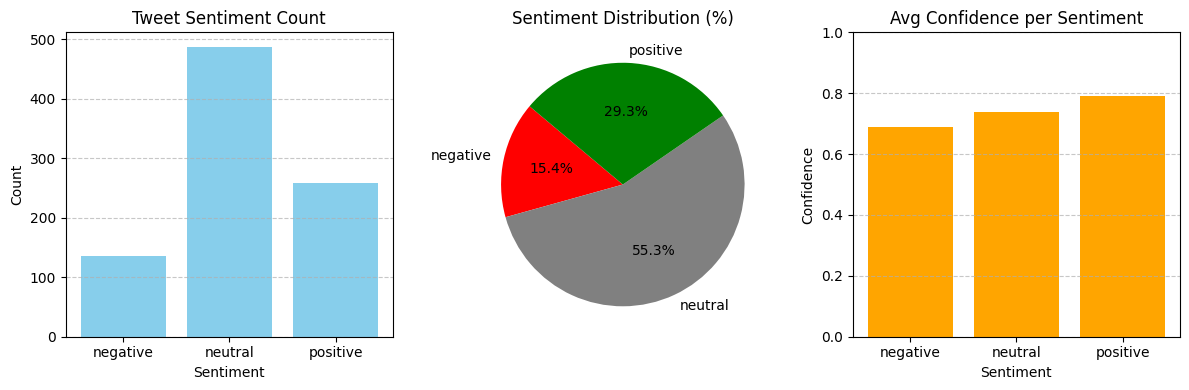

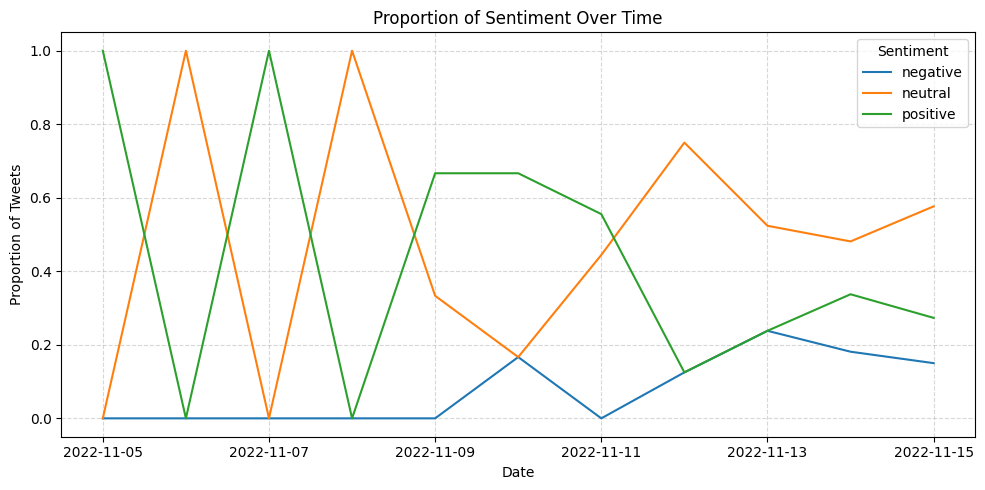

In [ ]:
# Set file path
output_path = cleanedds_folder / 'AItrust_pruned_twits_test_with_sentiment.json'

# ──────────────── Part 1: Overall Sentiment Distribution ────────────────
label_counts = Counter()
confidence_sums = Counter()
time_records = []

with open(output_path, 'r', encoding='utf-8') as f:
    for line in f:
        twit = json.loads(line)
        label = twit.get("sentiment_label")
        scores = twit.get("sentiment_score", {})
        created_at = twit.get("created_at")

        if label:
            label_counts[label] += 1
            confidence_sums[label] += scores.get(label, 0.0)

        # Collect for time-based analysis
        if created_at and label in scores:
            time_records.append({
                "date": created_at[:10],  # 'YYYY-MM-DD'
                "sentiment": label,
                "score": scores[label]
            })

# Prepare data for overall plots
labels = ['negative', 'neutral', 'positive']
counts = [label_counts.get(label, 0) for label in labels]
total = sum(counts)
percentages = [count / total * 100 for count in counts]
avg_confidence = [
    confidence_sums.get(label, 0.0) / label_counts.get(label, 1)
    for label in labels
]

# ──────────────── Plot 1-3: Overall Sentiment Distribution ────────────────
plt.figure(figsize=(12, 4))

# Count bar chart
plt.subplot(1, 3, 1)
plt.bar(labels, counts, color='skyblue')
plt.title("Tweet Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Pie chart
plt.subplot(1, 3, 2)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=['red', 'gray', 'green'])
plt.title("Sentiment Distribution (%)")

# Avg confidence
plt.subplot(1, 3, 3)
plt.bar(labels, avg_confidence, color='orange')
plt.title("Avg Confidence per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# # ──────────────── Part 2: Sentiment Over Time ────────────────
# # Create DataFrame from time records
# df = pd.DataFrame(time_records)
# df['date'] = pd.to_datetime(df['date'])

# # Daily average sentiment confidence
# daily_sentiment = df.groupby(['date', 'sentiment'])['score'].mean().unstack().fillna(0)

# # Plot time series
# plt.figure(figsize=(10, 5))
# for col in daily_sentiment.columns:
#     plt.plot(daily_sentiment.index, daily_sentiment[col], label=col)

# plt.title("Average Sentiment Confidence Over Time")
# plt.xlabel("Date")
# plt.ylabel("Avg Confidence")
# plt.legend(title="Sentiment")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

# ──────────────── Part 2: Sentiment Over Time (Proportion instead of Avg Confidence) ────────────────
# Create DataFrame from time records
df = pd.DataFrame(time_records)
df['date'] = pd.to_datetime(df['date'])

# Count tweets per sentiment per day
daily_counts = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

# Calculate proportions per day
daily_proportions = daily_counts.div(daily_counts.sum(axis=1), axis=0)

# Plot time series of proportions
plt.figure(figsize=(10, 5))
for col in daily_proportions.columns:
    plt.plot(daily_proportions.index, daily_proportions[col], label=col)

plt.title("Proportion of Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Proportion of Tweets")
plt.legend(title="Sentiment")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## For Full Data

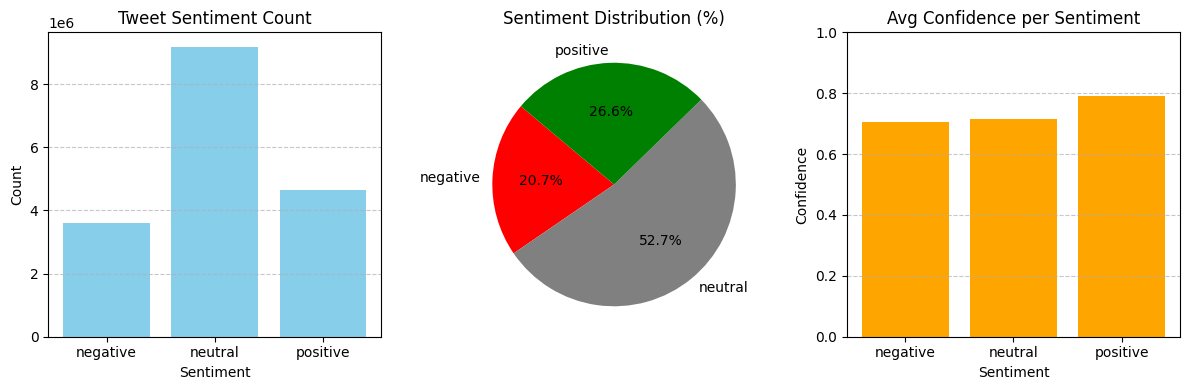

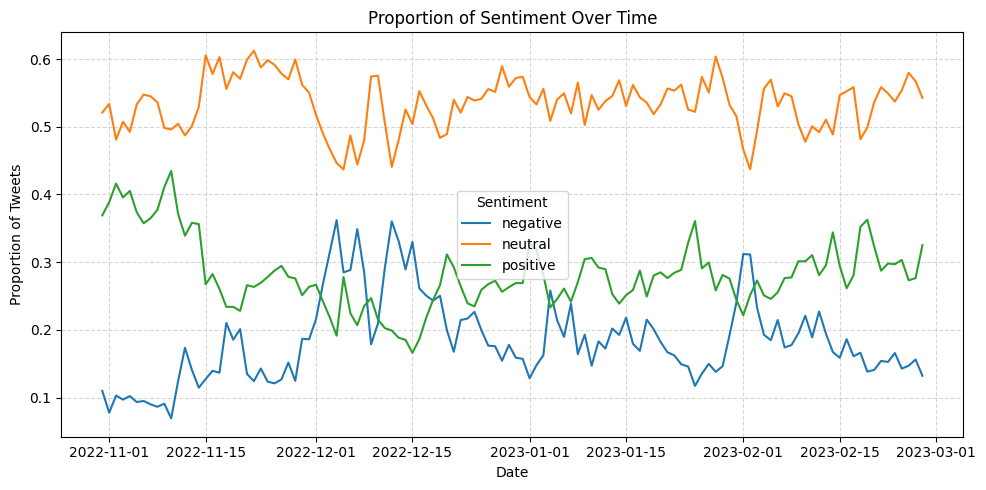

In [ ]:
# Set file path
output_path = cleanedds_folder / 'AItrust_pruned_twits_with_sentiment.json'

# ──────────────── Part 1: Overall Sentiment Distribution ────────────────
label_counts = Counter()
confidence_sums = Counter()
time_records = []

with open(output_path, 'r', encoding='utf-8') as f:
    for line in f:
        twit = json.loads(line)
        label = twit.get("sentiment_label")
        scores = twit.get("sentiment_score", {})
        created_at = twit.get("created_at")

        if label:
            label_counts[label] += 1
            confidence_sums[label] += scores.get(label, 0.0)

        # Collect for time-based analysis
        if created_at and label in scores:
            time_records.append({
                "date": created_at[:10],  # 'YYYY-MM-DD'
                "sentiment": label,
                "score": scores[label]
            })

# Prepare data for overall plots
labels = ['negative', 'neutral', 'positive']
counts = [label_counts.get(label, 0) for label in labels]
total = sum(counts)
percentages = [count / total * 100 for count in counts]
avg_confidence = [
    confidence_sums.get(label, 0.0) / label_counts.get(label, 1)
    for label in labels
]

# ──────────────── Plot 1-3: Overall Sentiment Distribution ────────────────
plt.figure(figsize=(12, 4))

# Count bar chart
plt.subplot(1, 3, 1)
plt.bar(labels, counts, color='skyblue')
plt.title("Tweet Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Pie chart
plt.subplot(1, 3, 2)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=['red', 'gray', 'green'])
plt.title("Sentiment Distribution (%)")

# Avg confidence
plt.subplot(1, 3, 3)
plt.bar(labels, avg_confidence, color='orange')
plt.title("Avg Confidence per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# # ──────────────── Part 2: Sentiment Over Time ────────────────
# # Create DataFrame from time records
# df = pd.DataFrame(time_records)
# df['date'] = pd.to_datetime(df['date'])

# # Daily average sentiment confidence
# daily_sentiment = df.groupby(['date', 'sentiment'])['score'].mean().unstack().fillna(0)

# # Plot time series
# plt.figure(figsize=(10, 5))
# for col in daily_sentiment.columns:
#     plt.plot(daily_sentiment.index, daily_sentiment[col], label=col)

# plt.title("Average Sentiment Confidence Over Time")
# plt.xlabel("Date")
# plt.ylabel("Avg Confidence")
# plt.legend(title="Sentiment")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

# ──────────────── Part 2: Sentiment Over Time (Proportion instead of Avg Confidence) ────────────────
# Create DataFrame from time records
df = pd.DataFrame(time_records)
df['date'] = pd.to_datetime(df['date'])

# Count tweets per sentiment per day
daily_counts = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

# Calculate proportions per day
daily_proportions = daily_counts.div(daily_counts.sum(axis=1), axis=0)

# Plot time series of proportions
plt.figure(figsize=(10, 5))
for col in daily_proportions.columns:
    plt.plot(daily_proportions.index, daily_proportions[col], label=col)

plt.title("Proportion of Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Proportion of Tweets")
plt.legend(title="Sentiment")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Disconnect From Runtime

In [ ]:
from datetime import datetime
import pytz
from IPython.display import Javascript

# Get current time in New York
nyc_time = datetime.now(pytz.timezone('America/New_York'))
formatted_time = nyc_time.strftime('%Y-%m-%d %H:%M:%S %Z')

# Print and log
print(f"✅ Disconnected from runtime at: {formatted_time}")

# Disconnect Colab runtime
display(Javascript('google.colab.kernel.disconnect()'))


✅ Disconnected from runtime at: 2025-08-26 00:19:49 EDT


<IPython.core.display.Javascript object>